In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from bbox_plotter import yolo_to_corners
from torchvision.ops import complete_box_iou_loss
import numpy as np
import csv
import cv2
import os
from bbox_plotter import visualize_prediction
import matplotlib.pyplot as plt

In [2]:
class ZebrafishDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
    

In [3]:
images_path = "E:\Code\CAMZ\data\interim\X_labelled_data.npy"
labels_path = "E:\Code\CAMZ\data\interim\y_labelled_data.npy"

transform = transforms.ToTensor()
dataset = ZebrafishDataset(images_path, labels_path, transform=transform)

train_size = int(0.8 * dataset.__len__())
val_size = dataset.__len__() - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [4]:
train_loader = DataLoader(dataset = train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size=16, shuffle=True)

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128 * 26 * 26, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=4)
        
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
                
        x = self.flatten(x)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x
        

In [4]:
class CompleteBoxLoss(nn.Module):
    def __init__(self):
        super(CompleteBoxLoss, self).__init__()

    def forward(self, pred_boxes, true_boxes, reduction):
        ciou = complete_box_iou_loss(pred_boxes, true_boxes, reduction)
        
        return ciou


In [5]:
model = CNNModel()
ciou_loss_function = CompleteBoxLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def Initialize_writer(file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, mode='w', newline="") as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'loss', 'val_loss'])

In [9]:
def validate(model, val_loader, loss_function):
    model.eval()
    ciou_total_batch_loss = 0.0
    
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = yolo_to_corners(model(inputs), image_width=720, image_height=720)
            labels = yolo_to_corners(labels, image_width=720, image_height=720)
            
            ciou_loss_per_batch = loss_function(outputs, labels, 'mean')
            
            ciou_total_batch_loss += ciou_loss_per_batch.item()
        
        
        ciou_total_loss = ciou_total_batch_loss / len(val_loader)
        
        
        print(f"CIoU: {ciou_total_loss:.4f}", end=" ")
        return ciou_total_loss

In [10]:
def train(model, train_loader, optimizer, 
          loss_function,
          history_csv_path, 
          save_model_checkpoint_path, num_epochs=1, patience=5):
    
    Initialize_writer(history_csv_path)
    
    
    best_val_ciou_loss = float('inf')
    
    model.train()
        
    for epoch in range(num_epochs):
        ciou_total_batch_loss = 0.0
         
        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            
            norm_labels = yolo_to_corners(labels, image_width=720, image_height=720)
            outputs = yolo_to_corners(model(inputs), image_width=720, image_height=720)
                     
            
            ciou_loss_per_batch = loss_function(outputs, norm_labels, 'mean')
            
            ciou_loss_per_batch.backward()
            
            optimizer.step()
            
            ciou_total_batch_loss += ciou_loss_per_batch.item()
            
        ciou_loss_per_epoch = ciou_total_batch_loss / len(train_loader)
        
        print(end='\n')
        print(f"Epoch [{epoch+1}/{num_epochs}], CIoU: {ciou_loss_per_epoch:.4f}", end=" --- ")
        print(f"Validation for Epoch [{epoch+1}/{num_epochs}]", end=", ")
        val_ciou_loss = validate(model, val_loader, loss_function)
        
        
        if val_ciou_loss < best_val_ciou_loss:
            best_val_ciou_loss = val_ciou_loss
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            print("\n")
            print(f"=========Saving Checkpoint======= at Epoch:[{epoch+1}/{num_epochs}]", end="\n")
            torch.save(checkpoint, save_model_checkpoint_path)
            early_stopping = 0
        
        else:
            early_stopping+=1 
            

        
        with open(history_csv_path, mode='a', newline="") as file:
            mse_writer = csv.writer(file)
            mse_writer.writerow([epoch+1, ciou_loss_per_epoch, val_ciou_loss])
        
        if early_stopping >= patience:
            print(f"Early stopping occured at {epoch+1}")
            break
             
    print(f"The best Validation Loss is: {best_val_ciou_loss}")
                

In [11]:
history_csv_file = "E:\Code\CAMZ\models\model_history/CNN_loss_logger.csv"
checkpoints_file = 'E:\Code\CAMZ\models\CNN_checkpoint.pth.tar'

In [12]:
train(model, train_loader, optimizer, ciou_loss_function,history_csv_path=history_csv_file,
      save_model_checkpoint_path=checkpoints_file, num_epochs=100)

C:\Users\HARSHU\AppData\Local\Temp\ipykernel_20756\83796796.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)



Epoch [1/100], CIoU: 1.0291 --- Validation for Epoch [1/100], CIoU: 1.0186 

=========Saving Checkpoint======= at Epoch:[1/100]

Epoch [2/100], CIoU: 1.0004 --- Validation for Epoch [2/100], CIoU: 0.9613 

=========Saving Checkpoint======= at Epoch:[2/100]

Epoch [3/100], CIoU: 0.7988 --- Validation for Epoch [3/100], CIoU: 0.6349 

=========Saving Checkpoint======= at Epoch:[3/100]

Epoch [4/100], CIoU: 0.5708 --- Validation for Epoch [4/100], CIoU: 0.5345 

=========Saving Checkpoint======= at Epoch:[4/100]

Epoch [5/100], CIoU: 0.4891 --- Validation for Epoch [5/100], CIoU: 0.5085 

=========Saving Checkpoint======= at Epoch:[5/100]

Epoch [6/100], CIoU: 0.4633 --- Validation for Epoch [6/100], CIoU: 0.4537 

=========Saving Checkpoint======= at Epoch:[6/100]

Epoch [7/100], CIoU: 0.4203 --- Validation for Epoch [7/100], CIoU: 0.4918 
Epoch [8/100], CIoU: 0.4301 --- Validation for Epoch [8/100], CIoU: 0.3985 

=========Saving Checkpoint======= at Epoch:[8/100]

Epoch [9/100], CIoU:

KeyboardInterrupt: 

The best loss of 0.3909008969775343 achieved at Epoch: 10


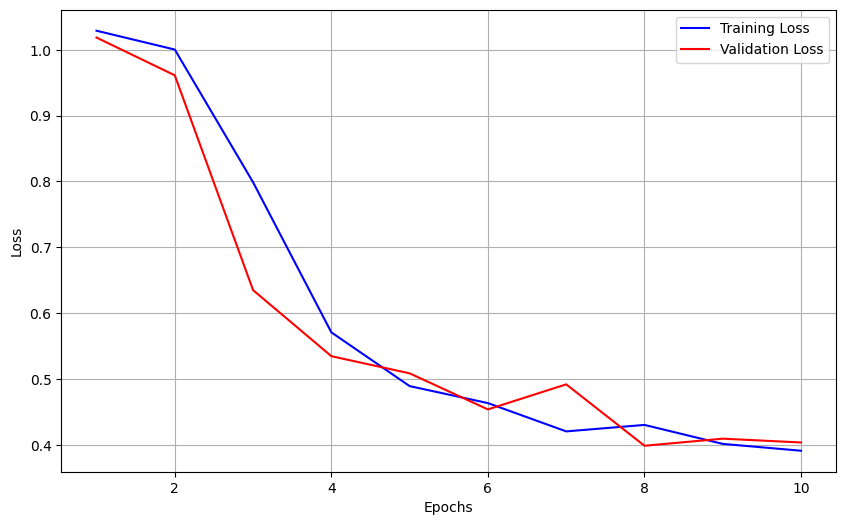

In [8]:
from loss_curve_visualization import plot_loss_curves
plot_loss_curves("E:\Code\CAMZ\models\model_history/CNN_loss_logger.csv")

In [6]:
def load_checkpoint(checkpoint, architecture, optimizer):
    print("loading checkpoint...")
    checkpoint = torch.load(checkpoint)
    
    model = architecture()
    
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    return model.eval()
model = load_checkpoint("E:\Code\CAMZ\models\CNN_checkpoint.pth.tar", CNNModel, optimizer)

loading checkpoint...


C:\Users\HARSHU\AppData\Local\Temp\ipykernel_13936\1324638982.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint)


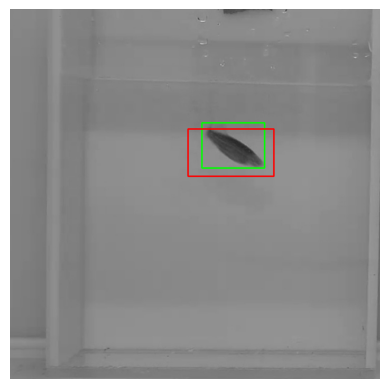

In [7]:
image_path1 = r"E:\DIL\Fish_classification_ViT\data\1Lcrop989.jpg.jpg"
image_path2 = r"E:\DIL\Fish_classification_ViT\data\1Lcrop284.jpg.jpg"
image_path3 = r"E:\DIL\Fish_classification_ViT\data\1Lcrop313.jpg.jpg"

visualize_prediction(image_path1, labels_path=r"E:\DIL\Fish_classification_ViT\data\labels",
                     model=model)
    

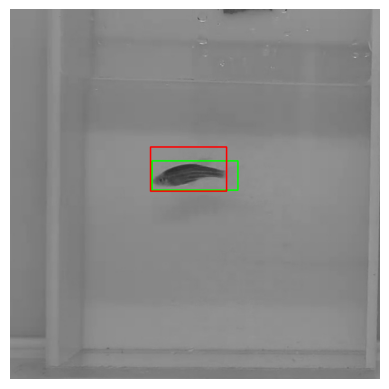

In [8]:
visualize_prediction(image_path2, labels_path=r"E:\DIL\Fish_classification_ViT\data\labels",
                     model=model)

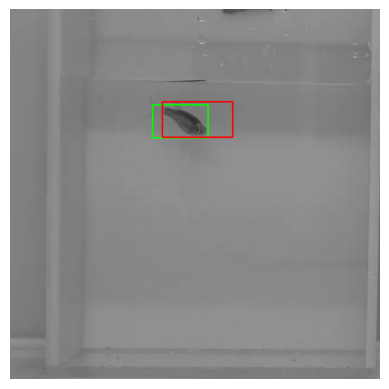

In [9]:
visualize_prediction(image_path3, labels_path=r"E:\DIL\Fish_classification_ViT\data\labels",
                     model=model)